In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.multitest import fdrcorrection
import re

In [2]:
taxonomy_deep = pd.read_pickle('preprocessed_data/rarefied_kraken_species_level_taxonomy_filtered_ra.pkl')

# blood = pd.read_pickle('preprocessed_data/blood_measurments_preprocessed.pkl')
# blood = blood.rename(columns= lambda x: re.sub('_result_all_m_1','',x))

blood_metabolites = pd.read_pickle('preprocessed_data/blood_metabolites_preprocessed.pkl')

In [ ]:
# Should we remove outliers before prediction? Or consider them in any why? 
# blood = blood.where((blood >= -4) & (blood <= 4))

In [7]:
blood_metabolites.shape

(1440, 215)

Correlation matrix.

In [4]:
blood_metabolites_microbiome_corr_coef = pd.DataFrame(index=taxonomy_deep.columns, columns=blood_metabolites.columns)
blood_metabolites_microbiome_p_values = pd.DataFrame(index=taxonomy_deep.columns, columns=blood_metabolites.columns)

for metabolite in blood_metabolites.columns:
    for taxa in taxonomy_deep.columns:
        # Lets align the measurments and the taxa:
        taxa_ , blood_m = taxonomy_deep[taxa].align(blood_metabolites[metabolite].dropna(), join = 'inner')
        coefficient, p  = stats.kendalltau(blood_m, taxa_)
        blood_metabolites_microbiome_corr_coef.loc[taxa, metabolite] = coefficient
        blood_metabolites_microbiome_p_values.loc[taxa, metabolite] = p
        

In [5]:
# Currently we will continue without FDR correction and look only of the Correlation Coefficient but if we will want: 
_, p_values_corrected = fdrcorrection(blood_metabolites_microbiome_p_values.stack())
blood_metabolites_microbiome_p_values_corrected = pd.Series(p_values_corrected, index=blood_metabolites_microbiome_p_values.stack().index).unstack()

In [6]:
print(f"{(blood_metabolites_microbiome_p_values_corrected < 0.05).sum().sum()} couples are significant out of {blood_metabolites_microbiome_p_values_corrected.size} aka {round(100 * (blood_metabolites_microbiome_p_values_corrected < 0.05).sum().sum() /blood_metabolites_microbiome_p_values_corrected.size, 2)} %")

14654 couples are significant out of 65575 aka 22.35 %


In [9]:
blood_metabolites_microbiome_p_values_corrected = blood_metabolites_microbiome_p_values_corrected.T.stack()
blood_metabolites_microbiome_significant_corr_coef = blood_metabolites_microbiome_corr_coef.T.stack()[blood_metabolites_microbiome_p_values_corrected < 0.05]
blood_metabolites_microbiome_significant_corr_coef = blood_metabolites_microbiome_significant_corr_coef.unstack().T

In [11]:
blood_metabolites_microbiome_p_values_corrected.to_pickle('results/blood_metabolites_microbiome_p_values_corrected.pkl')
blood_metabolites_microbiome_p_values.to_pickle('results/blood_metabolites_microbiome_p_values.pkl')
blood_metabolites_microbiome_corr_coef.to_pickle('results/blood_metabolites_microbiome_corr_coef.pkl')

[Text(0.5, 1.0, 'Correlation coef of Blood Metabolites & Microbiome')]

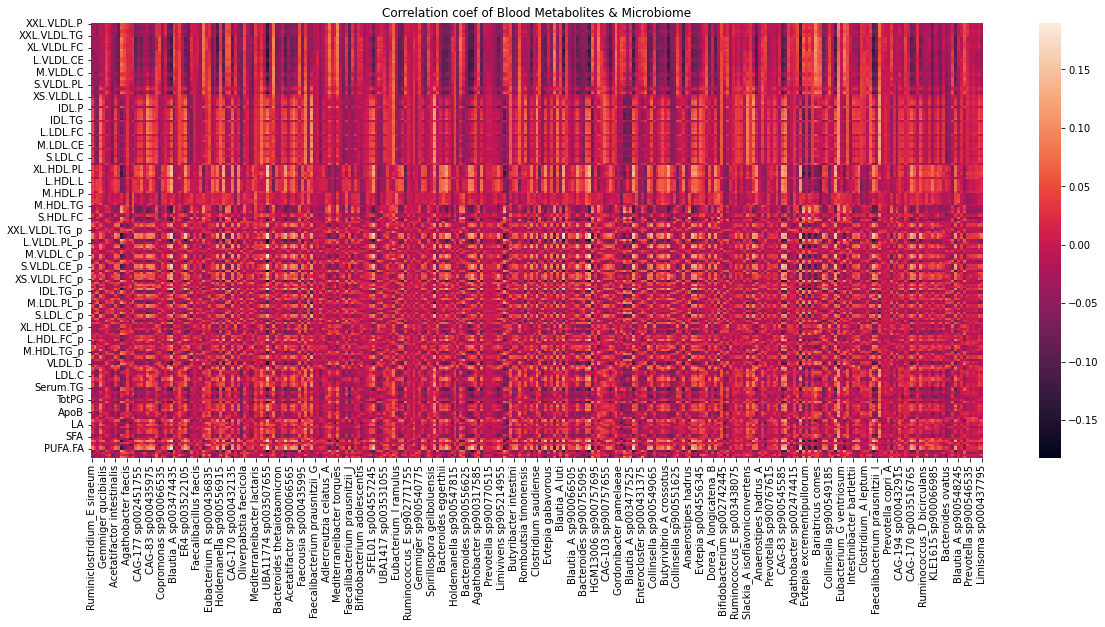

In [12]:
# Visaulize correlation heatmap: 
fig, axes = plt.subplots(figsize=(20,8))
sns.heatmap(blood_metabolites_microbiome_corr_coef.T.astype(float)).set(title='Correlation coef of Blood Metabolites & Microbiome')

Seems like there are strong correlation between the metabolites as well.

[Text(0.5, 1.0, 'Correlation coef of Blood Metabolites & Microbiome')]

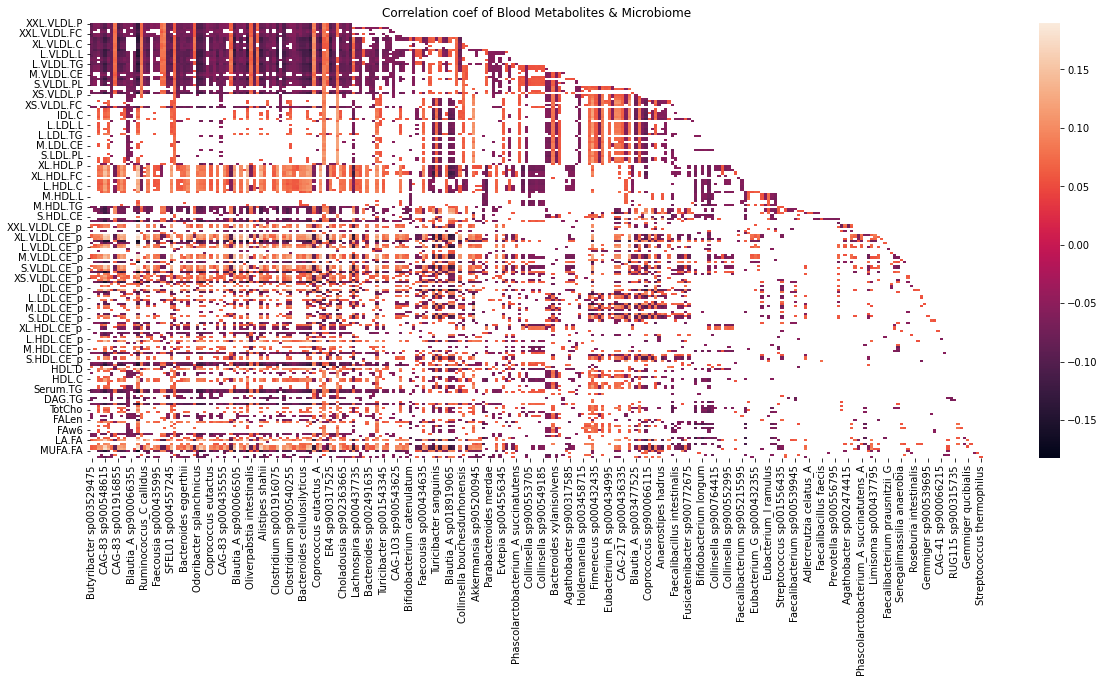

In [13]:
fig, axes = plt.subplots(figsize=(20,8))
sns.heatmap(blood_metabolites_microbiome_significant_corr_coef.T.astype(float)).set(title='Correlation coef of Blood Metabolites & Microbiome')

We can see some blood measurment are signifcantly correlated with the microbiome, and some are not. 

For example, triglyceride is higly correlated with the microbiome, 
with taxa such as: Ruminococcus_B gnavus and Mediterraneibacter torques with positive correlation,
and taxa such as: UBA11774 sp003507655 and CAG-83 sp900548615 with negative correlation. 

While other blood measurment such as basoconc have almost no significant correlation with the microbiome.

In [15]:
blood_metabolites_microbiome_significant_corr_coef['XXL.VLDL.P'].astype(float).nsmallest(n=5)

UBA11774 sp003507655        -0.132303
Faecousia sp003525905       -0.103914
Dysosmobacter sp001916835   -0.103620
UBA11524 sp000437595        -0.103461
Odoribacter splanchnicus    -0.101914
Name: XXL.VLDL.P, dtype: float64

In [16]:
blood_metabolites_microbiome_significant_corr_coef['XXL.VLDL.P'].astype(float).nlargest(n=5)

Mediterraneibacter torques        0.093360
Ruminococcus_B gnavus             0.089880
Lawsonibacter asaccharolyticus    0.086153
Dorea formicigenerans             0.080228
Acutalibacter ornithocaccae       0.079963
Name: XXL.VLDL.P, dtype: float64

Prediction of Blood measumerments / Blood metabolite from microbiome community

Robustly Well Predict blood-measurements/ blood-metabolite. 
Predict target using Random Forest (default hyper-parameters) using leave-one-subject-out cross validation. 


Predict metabolite levels:
 train a random forest regression model to predict metabolite levels based on genera relative abundances (with default hyper-parameter as done in Efrat's paper)
  evaluated each model’s performance using leave-one-subject-out cross validation by calculating the Spearman’s correlation coefficient, ρ, between actual vs predicted left out metabolite levels. Spearman’s correlation P value was also recorded, and FDR-correction was applied to all metabolite-models in each dataset (see “Methods” section). Metabolites with a predictability of ρ > 0.3 and an FDR < 0.1 were referred to as ‘well-predicted’ metabolites. 


In [ ]:
# Should we remove outliers before prediction? Or consider them in any why? 
# blood = blood.where((blood >= -4) & (blood <= 4)) - after standard normalizer. Corrently I don't but we could in the final analysis.

In [17]:
# Here each sample is a subject, so we have leave-one-out cross validation. 

# TODO: Predict for each and every one of the blood measurement and save the results under 'results' 

# TODO: I will need to parrallelize the computation as it takes ~30 seconds for itteration and we have 1,000 samples. So LOO is 1000 iteration. Which will take ~5 hourse
# Per target. So I need to create a script and run it in their 'slurm', saving for each target the loo_prediction in a file. 

m_name = 'XXL.VLDL.P'
from tqdm import tqdm

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

random_state = 40

X = taxonomy_deep
y = blood_metabolites[m_name]

X, y = X.align(y.dropna(), join = 'inner', axis=0)

kfold_cv = KFold(n_splits=10)
cv_pred = []

for train_index, test_index in tqdm(kfold_cv.split(X=X, y=y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    reg = RandomForestRegressor(random_state=random_state)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    cv_pred.append(pd.Series(y_pred, index=X_test.index))


cv_pred = pd.concat(cv_pred)
cv_pred.name = m_name
cv_pred.to_pickle(f'results/blood_metabolites/kfold_pred_v0_default_rf_{m_name}.pkl')

# TODO: Evaluate 'well-predictability' as well as other basic evaluation metrics. 

10it [03:46, 22.62s/it]


<Axes: ylabel='Frequency'>

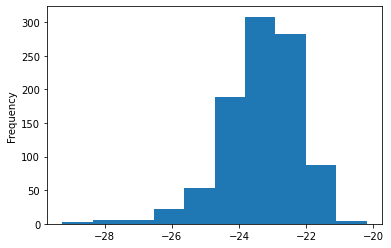

In [25]:
y.plot.hist()

<Axes: ylabel='Frequency'>

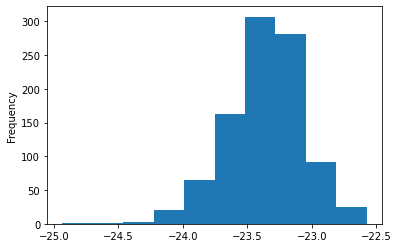

In [23]:
cv_pred.plot.hist()

In [27]:
y

LLDeep_0001   -24.432348
LLDeep_0002   -22.574775
LLDeep_0006   -20.198537
LLDeep_0007   -23.111409
LLDeep_0011   -24.486869
                 ...    
LLDeep_1530   -23.947154
LLDeep_1539   -23.214593
LLDeep_1542   -22.405274
LLDeep_1545   -22.818837
LLDeep_1546   -23.072943
Name: XXL.VLDL.P, Length: 958, dtype: float64

In [26]:
cv_pred

LLDeep_0001   -23.629871
LLDeep_0002   -23.481734
LLDeep_0006   -23.298860
LLDeep_0007   -23.571230
LLDeep_0011   -23.201282
                 ...    
LLDeep_1530   -23.384472
LLDeep_1539   -23.957509
LLDeep_1542   -22.996616
LLDeep_1545   -23.358663
LLDeep_1546   -23.134025
Name: XXL.VLDL.P, Length: 958, dtype: float64

In [ ]:
# TODO: I calculated the correlation metric and the predictability with respect to blood measurements.
# Apply with respect to metabolite levels?